# CS 5670: Computer Vision   --  Home Work 2
## Naveen (nlp49), Yanbo (yl2556)
### Task 1 
### 1.1 Gaussian Pyramid
There are two ways to do the pyramid reduce or expand--one is using convolve2d to smoothen the image (reference: https://compvisionlab.wordpress.com/2013/05/13/image-blending-using-pyramid/), and the other way is using gaussianBlur to blur the image. Here we tried both in reduce and expand. But before that, we first flatten the image from the 3 original channels to 1.

Gaussian pyramid for Mandrill:


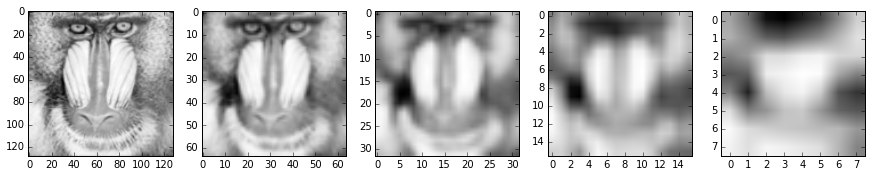

Gaussian pyramid for Toucan:


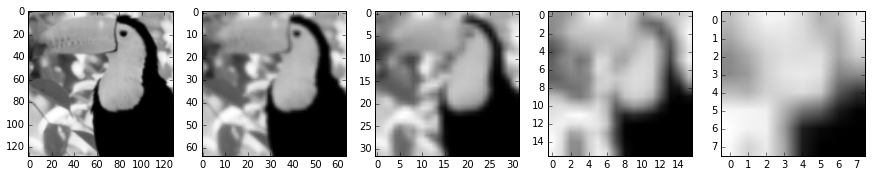

In [51]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from scipy.signal import convolve2d
from skimage.transform import resize
from scipy.misc import imread

A = imread('./Images/Q1/mandril.tif',flatten=1)/255.0
B = imread('./Images/Q1/toucan.tif',flatten=1)/255.0

def display(img, colormap=cm.Greys):
    plt.imshow(img, cmap = colormap)
    plt.show()

def gaussian_scale(img, scale = 0.5):
    rows = img.shape[0]
    cols = img.shape[1]
    out_rows = math.ceil(scale * rows)
    out_cols = math.ceil(scale * cols)
    img_new = img
    if(scale>1):
        img_new = resize(img_new, (out_rows, out_cols), order=1,mode='reflect', cval=0)
    img_new = cv2.GaussianBlur(img_new,(5,5), sigmaX=1)
    if(scale<=1):
        img_new = resize(img_new, (out_rows, out_cols), order=1,mode='reflect', cval=0)
    return img_new

def gaussian_pyramid(img,n):
    G = img.copy()
    pyramid = [G] # or = [G]
    f, axes = plt.subplots(ncols=n, figsize=(15,15))
    for i in xrange(n):
        G = gaussian_scale(G)
        pyramid.append(G)
        axes[i].imshow(G, cmap = cm.Greys_r)
    plt.show()
    return pyramid

print "Gaussian pyramid for Mandrill:"
A_gp = gaussian_pyramid(A,5)
print "Gaussian pyramid for Toucan:"
B_gp = gaussian_pyramid(B,5)

### 1.2 Laplacian Pyramid
Laplacian pyramid level is built by taking a certain gaussian level and subtracting an expansion of the smaller level below it. As can be seen in the plt below, image B (toucan.tif, at the bottom) has more obvious edge comparing with image A (mandril.tif, on the top). We believe that it is because that B has larger contrast in brightness, which makes the edge more clear after subtracted the blurry one.

Laplacian pyramid for Mandrill:


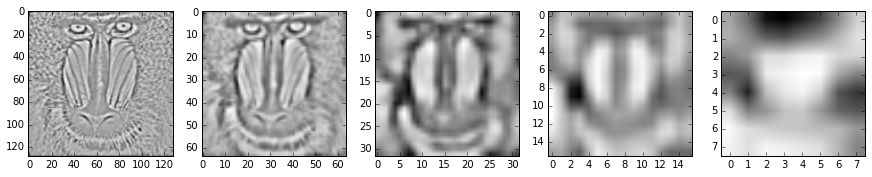

Laplacian pyramid for Toucan:


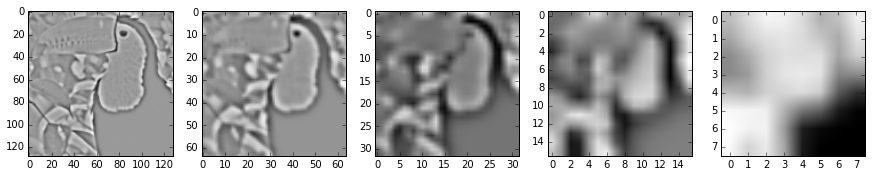

In [52]:
def laplacian_pyramid(GP,n):
    LP = [GP[n]]
    f, axes = plt.subplots(ncols=n, figsize=(15,15))
    for i in xrange(n,0,-1):
        GE = gaussian_scale(GP[i], 2)
        L = np.subtract(GP[i-1],GE)
        L_show = map(lambda x:(x+1)/2, L)
        LP.append(L)
    
    for i in xrange(n):
        axes[i].imshow(LP[n-i-1], cmap = cm.Greys_r)
    plt.show()
    return LP

print "Laplacian pyramid for Mandrill:"
A_lp = laplacian_pyramid(A_gp,5)
print "Laplacian pyramid for Toucan:"
B_lp = laplacian_pyramid(B_gp,5)

### 1.3 Image Reconstruction 
As shown in the image below, the reconstructed image looks really similar to the original image. The difference is on image A's monkey eye and image B's black body area. Possible reason for having a large area in B is because that low value get higher as blurring, so it's more difficult to reconstruct.

In [56]:
A_r

array([[ 0.37810066,  0.24478961,  0.37082897, ...,  0.3464813 ,
         0.49532252,  0.58552762],
       [ 0.3976607 ,  0.26830334,  0.30811748, ...,  0.46415408,
         0.3737025 ,  0.27566049],
       [ 0.39326981,  0.39731783,  0.30382928, ...,  0.37390042,
         0.25577448,  0.49883715],
       ..., 
       [ 0.40458451,  0.55358318,  0.54174355, ...,  0.39353051,
         0.36234062,  0.33491072],
       [ 0.56594828,  0.60518123,  0.53467526, ...,  0.39426968,
         0.38256547,  0.36297191],
       [ 0.32268582,  0.26780266,  0.24831802, ...,  0.1785315 ,
         0.17073596,  0.15507481]])

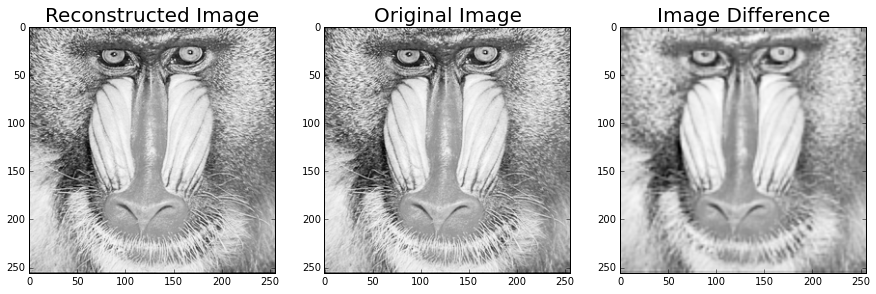

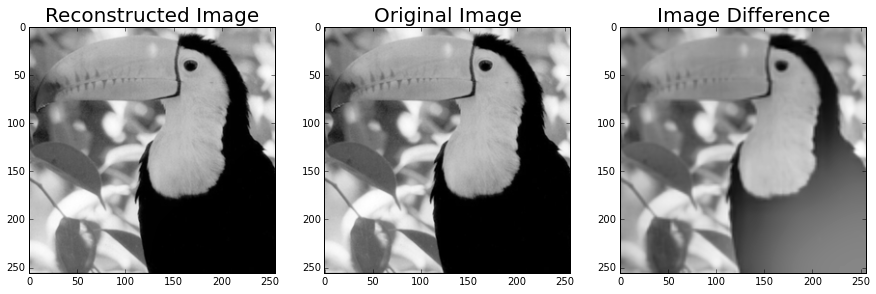

In [53]:
def Reconstruction(LP,n):
    L = LP[0]
    for i in xrange(1,len(LP)):
        L = pyramid_expand(L)
        L = np.add(L,LP[i])
    return L

def display_diff(img_r,img):
    f, axes = plt.subplots(ncols=3, figsize=(15,15))
    axes[0].set_title('Reconstructed Image',fontsize=20)
    axes[0].imshow(img_r, cmap = cm.Greys_r)
    
    axes[1].set_title('Original Image',fontsize=20)
    axes[1].imshow(img, cmap = cm.Greys_r)
    
    axes[2].set_title('Image Difference',fontsize=20)
    img_sub = np.subtract(img,img_r)
    axes[2].imshow(img_sub,cmap = cm.Greys_r)
    
    plt.show()
    
A_r = Reconstruction(A_lp,4)
B_r = Reconstruction(B_lp,4)

display_diff(A_r,A)
display_diff(B_r,B)

### 1.4 Image Enhancement 
First, construct a 4 level laplacian pyramid for both focus1 (C) and focus2 (D)

Then, use each of the level(j) to define a mask(j) image, which is 1 when $C[j]>D[j]$, and 0 elsewise 

Third, form the blended pyramid levels with $X[j]=Mask[j]C[j]+(1-Mask[j])D[j]$

Finally, reconstruct the image with the blended pyramid levels, and show the enhanced image

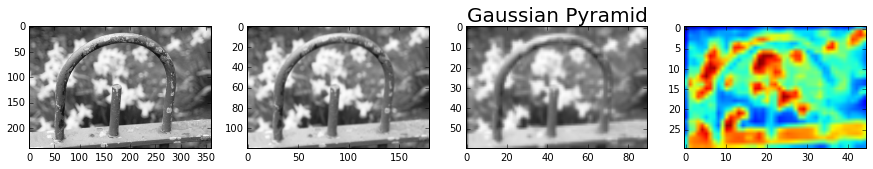

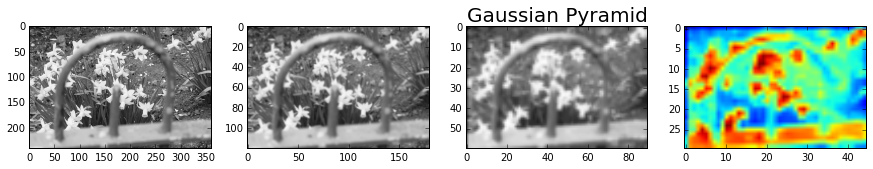

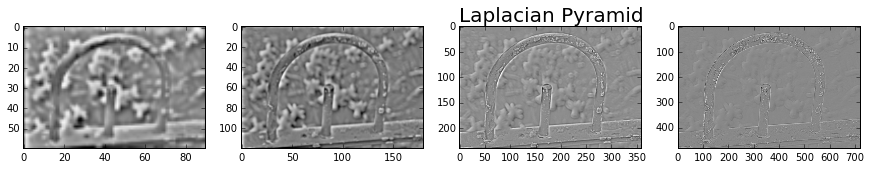

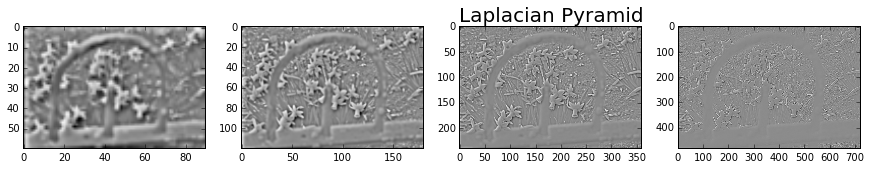

In [4]:
C_1 = cv2.imread('focus1.tif',0)
D_1 = cv2.imread('focus2.tif',0)
C = resize(C_1, (480,720), order=1,mode='constant', cval=0)
D = resize(D_1, (480,720), order=1,mode='constant', cval=0)
C_gp = gaussian_pyramid(C,4)
D_gp = gaussian_pyramid(D,4)
C_lp = laplacian_pyramid(C_gp,4)
D_lp = laplacian_pyramid(D_gp,4)

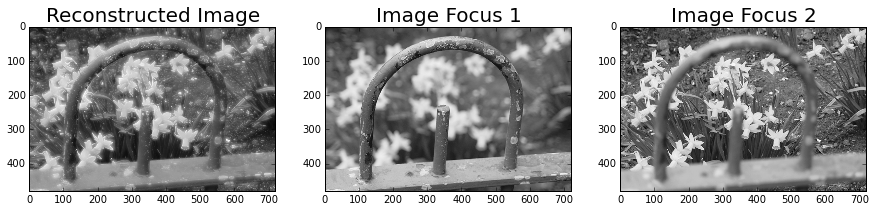

In [5]:
X=[]
for j in xrange(0,5,1):
    img_diff = np.subtract(C_lp[j],D_lp[j])
    mask = (img_diff > 0).astype(int)
    x_1 = 1-mask
    x = np.add(np.multiply(mask,C_lp[j]),np.multiply(x_1,D_lp[j]))
    X.append(x)
    
X_r = Reconstruction(X,4)
f, axes = plt.subplots(ncols=3, figsize=(15,15))
axes[0].imshow(X_r, cmap = cm.Greys_r)
axes[0].set_title('Reconstructed Image',fontsize=20)
axes[1].imshow(C, cmap = cm.Greys_r)
axes[1].set_title('Image Focus 1',fontsize=20)
axes[2].imshow(D,cmap = cm.Greys_r)
axes[2].set_title('Image Focus 2',fontsize=20)
plt.show()